# Lale: Type-Driven Auto-ML with Scikit-Learn

### https://github.com/ibm/lale

### Example Dataset

In [1]:
!pip install 'liac-arff>=2.4.0'

In [2]:
import lale.datasets.openml
import pandas as pd
(train_X, train_y), (test_X, test_y) = lale.datasets.openml.fetch(
    'credit-g', 'classification', preprocess=False)
pd.concat([pd.DataFrame({'y': train_y}, index=train_X.index).tail(),
           train_X.tail()], axis=1)

,y,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,...,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
835,0,<0,12.0,no credits/all paid,new car,1082.0,<100,1<=X<4,4.0,male single,...,4.0,car,48.0,bank,own,2.0,skilled,1.0,none,yes
192,0,0<=X<200,27.0,existing paid,business,3915.0,<100,1<=X<4,4.0,male single,...,2.0,car,36.0,none,own,1.0,skilled,2.0,yes,yes
629,1,no checking,9.0,existing paid,education,3832.0,no known savings,>=7,1.0,male single,...,4.0,real estate,64.0,none,own,1.0,unskilled resident,1.0,none,yes
559,0,0<=X<200,18.0,critical/other existing credit,furniture/equipment,1928.0,<100,<1,2.0,male single,...,2.0,real estate,31.0,none,own,2.0,unskilled resident,1.0,none,yes
684,1,0<=X<200,36.0,delayed previously,business,9857.0,100<=X<500,4<=X<7,1.0,male single,...,3.0,life insurance,31.0,none,own,2.0,unskilled resident,2.0,yes,yes


### Algorithm Selection and Hyperparameter Tuning

Lale supports 144 operators from various open-source libraries.
Just import the operators, then call `wrap_imported_operators`
to augment them with schemas to support auto-ML.

In [3]:
from sklearn.preprocessing import Normalizer as Norm
from sklearn.preprocessing import OneHotEncoder as OneHot
from sklearn.linear_model import LogisticRegression as LR
from xgboost import XGBClassifier as XGBoost
from sklearn.svm import LinearSVC
from lale.operators import make_pipeline, make_union
from lale.lib.lale import Project, ConcatFeatures, NoOp
import lale
lale.wrap_imported_operators()

Lale supports algorithm selection with the `|` combinator.
This example uses `|` in the preprocessing path for numbers to make
the normalization optional,
and it also uses `|` at the end to specify a choice of classifiers.
Lale support hyperparameter tuning by letting you omit hyperparameters.
This example does not bind any hyperparameters for `LR`,
so all of them are free to be tuned automatically.
This example binds the `dual` hyperparameter for `LinearSVC` by hand,
but leaves the remaining hyperparameters
(such as `C` and `tol`) free to be tuned automatically.

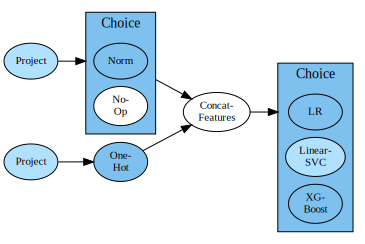

In [4]:
planned_pipeline = make_pipeline(
    make_union(
        make_pipeline(Project(columns={'type': 'number'}), Norm | NoOp),
        make_pipeline(Project(columns={'type': 'string'}), OneHot)),
    (LR | LinearSVC(dual=False)| XGBoost))
planned_pipeline.visualize()

In [5]:
import sklearn.metrics
from lale.lib.lale import Hyperopt
auto_optimizer = Hyperopt(estimator=planned_pipeline, cv=3, max_evals=20)
auto_trained = auto_optimizer.fit(train_X, train_y)
auto_y = auto_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, auto_y):.1%}')

100%|██████████| 20/20 [05:15<00:00, 18.64s/it, best loss: -0.7507273649370062]
accuracy 72.1%


### Displaying Automation Results

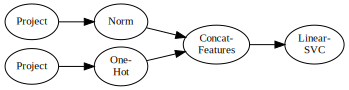

In [6]:
best_pipeline = auto_trained.get_pipeline()
best_pipeline.visualize()

In [7]:
from lale.pretty_print import ipython_display
ipython_display(best_pipeline, show_imports=False)

```python
project_0 = Project(columns={'type': 'number'})
norm = Norm(norm='l1')
project_1 = Project(columns={'type': 'string'})
linear_svc = LinearSVC(dual=False, C=9773.459065896624, tol=0.0006905227182226334)
pipeline = ((project_0 >> norm) & (project_1 >> OneHot())) >> ConcatFeatures() >> linear_svc
```

### JSON Schemas

https://json-schema.org/

In [8]:
ipython_display(XGBoost.hyperparam_schema('n_estimators'))

```python
{
    'description': 'Number of trees to fit.',
    'type': 'integer',
    'default': 100,
    'minimumForOptimizer': 10,
    'maximumForOptimizer': 1500}
```

In [9]:
ipython_display(XGBoost.hyperparam_schema('booster'))

```python
{
    'description': 'Specify which booster to use.',
    'enum': ['gbtree', 'gblinear', 'dart'],
    'default': 'gbtree'}
```

In [10]:
import jsonschema
import sys
try:
    XGBoost(n_estimators=0.5, booster='gbtree')
except jsonschema.ValidationError as e:
    print(e.message, file=sys.stderr)

Invalid configuration for XGBoost(n_estimators=0.5, booster='gbtree') due to invalid value n_estimators=0.5.
Schema of argument n_estimators: {
    'description': 'Number of trees to fit.',
    'type': 'integer',
    'default': 100,
    'minimumForOptimizer': 10,
    'maximumForOptimizer': 1500}
Value: 0.5


### Customizing Schemas

In [11]:
import lale.schemas as schemas
Grove = XGBoost.customize_schema(
    n_estimators=schemas.Int(min=2, max=10),
    booster=schemas.Enum(['gbtree']))

In [12]:
grove_planned = ( Project(columns={'type': 'number'}) >> Norm
                & Project(columns={'type': 'string'}) >> OneHot
                ) >> ConcatFeatures >> Grove

In [13]:
grove_optimizer = Hyperopt(estimator=grove_planned, cv=3, max_evals=50)
grove_trained = grove_optimizer.fit(train_X, train_y)
grove_y = grove_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, grove_y):.1%}')

100%|██████████| 50/50 [11:06<00:00, 11.65s/it, best loss: -0.7597026478752936]
accuracy 73.0%


In [14]:
grove_best = grove_trained.get_pipeline()
ipython_display(grove_best, show_imports=False)

```python
project_0 = Project(columns={'type': 'number'})
norm = Norm(norm='max')
project_1 = Project(columns={'type': 'string'})
xg_boost = XGBoost(booster='gbtree', colsample_bylevel=0.9991185233547285, colsample_bytree=0.6841880284404476, learning_rate=0.5688311296227547, max_depth=18, min_child_weight=4, n_estimators=7, reg_alpha=0.6151442217839537, reg_lambda=0.4949404520343076, subsample=0.9045499789623938)
pipeline = ((project_0 >> norm) & (project_1 >> OneHot())) >> ConcatFeatures() >> xg_boost
```

### Human-in-the-Loop Auto-ML

### https://github.com/ibm/lale

<img src="img/2019-1208-loops.png" style="width:700px" align="left">